#Adat előkészítés

In [ ]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.41 s (started: 2024-11-23 17:41:06 +00:00)


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.nn import functional as F
from collections import Counter, defaultdict

from collections import Counter
import re

with open('Petofi_corpus_joined.txt', 'r', encoding='utf-8') as f:
    text = f.read()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class BPETokenizer:
    def __init__(self):
        self.encoder = {}
        self.decoder = {}
        self.eol_token = '</l>'
        self.space_token = '</s>'
        self.vocab = [(self.eol_token,), (self.space_token,)]

    def build_vocab(self, input, additional_vocab_size=200):
        # Ensure every character is in the initial vocabulary
        chars = sorted(set(input.replace(' ', '').replace('\n', '')))
        self.vocab.extend([(char,) for char in chars])  # Each character is a tuple

        # Split text into lines with special tokens
        modified_lines = []
        for line in input.splitlines():
            modified_line = []
            for char in line:
                if char == ' ':
                    modified_line.append(self.space_token)
                else:
                    modified_line.append(char)
            modified_lines.append(' '.join(modified_line + [self.eol_token]))

        line_freq = Counter(modified_lines)

        for _ in range(additional_vocab_size - len(self.vocab)):
            pairs = self.get_pairs(line_freq)

            if not pairs:
                break

            most_common = max(pairs, key=pairs.get)
            self.vocab.append(most_common)

            # Merge the most frequent pair in the vocabulary
            line_freq = self.merge_pair_in_vocab(most_common, line_freq)

        # Create encoder and decoder mappings
        unique_tokens = [''.join(token) for token in self.vocab]
        self.encoder = {token: idx for idx, token in enumerate(unique_tokens)}
        self.decoder = {idx: token for token, idx in self.encoder.items()}

    def get_pairs(self, line_freq):
        """Get character pairs in all lines."""
        pairs = Counter()
        for line, freq in line_freq.items():
            symbols = line.split()
            for i in range(len(symbols) - 1):
                pairs[(symbols[i], symbols[i + 1])] += freq
        return pairs

    def merge_pair_in_vocab(self, pair, line_freq):
        """Merge a pair of symbols in the vocabulary."""
        new_line_freq = {}
        bigram = ' '.join(pair)
        replacement = ''.join(pair)

        for line, freq in line_freq.items():
            # Replace whole-word matches of the bigram
            new_line = line.replace(bigram, replacement)
            new_line_freq[new_line] = freq

        return new_line_freq

    def encode(self, input):
        """Encode text line by line using the BPE vocabulary."""
        tokens = []
        for line in input.splitlines():
            modified_line = []
            for char in line:
                if char == ' ':
                    modified_line.append(self.space_token)
                else:
                    modified_line.append(char)
            # line = ' '.join(modified_line + [self.eol_token])

            # Replace tokens based on vocab from longest to shortest
            for token in sorted(self.vocab, key=lambda x: -len(''.join(x))):
              modified_line[5 : 8] = [''.join(test_list[5 : 8])]

              token_str = ' '.join(token)
              line = re.sub(rf'(?<!\S){re.escape(token_str)}(?!\S)', ''.join(token), line)

            # Split into final tokens while preserving boundaries
            tokens.extend(line.split())

        result_tokens = [self.encoder[token] for token in tokens if token in self.encoder]
        if result_tokens:
          return result_tokens
        return [self.encoder[self.eol_token]]

    def decode(self, token_ids):
        """Decode token IDs back into text."""
        tokens = [self.decoder[token_id] for token_id in token_ids]
        return ''.join(tokens).replace(self.space_token, ' ').replace(self.eol_token, '\n')

time: 5.48 ms (started: 2024-11-23 19:54:37 +00:00)


In [ ]:
tokenizer = BPETokenizer()
tokenizer.build_vocab(text, 1000)

time: 4min 1s (started: 2024-11-23 19:55:41 +00:00)


In [ ]:
encoded_lines = []
vocab_size = len(tokenizer.vocab)

for line in text.splitlines():
  encoded_lines.append(torch.tensor(tokenizer.encode(line), dtype=torch.long))

delimiter = int(0.9 * len(encoded_lines))
train_data = encoded_lines[:delimiter]
val_data = encoded_lines[delimiter:]

KeyboardInterrupt: 

time: 12min 7s (started: 2024-11-23 19:59:54 +00:00)


#A modell

In [ ]:
batch_size = 16
block_size = 32

eval_iters = 200
n_embd = 256
n_head = 4
n_layer = 4
dropout = 0.0

# Adat betöltése
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    x_batch, y_batch = [], []

    ix = torch.randint(len(data)-1, (batch_size,))

    for i in ix:
      selected_data = data[i]
      j = i
      # we overfill, and then cut
      while len(selected_data) < block_size + 1:
        j = (j + 1) % len(data)
        try:
          selected_data = torch.cat((selected_data, data[j]))
        except:
          print("Error: ", j, len(data))
          raise Exception("A thing happened")
      selected_data = selected_data[:block_size + 1]

      x_batch.append(selected_data[:-1])
      y_batch.append(selected_data[1:])

    x = torch.stack(x_batch).to(device)
    y = torch.stack(y_batch).to(device)
    return x, y

# Loss function
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * C**-0.5 # this line is interesting: TODO
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

model = BigramLanguageModel().to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

3.208277 M parameters
time: 188 ms (started: 2024-11-23 18:18:41 +00:00)


#Tanítás

In [ ]:
train_loss_4 = []
valid_loss_4 = []

time: 393 µs (started: 2024-11-23 18:18:49 +00:00)


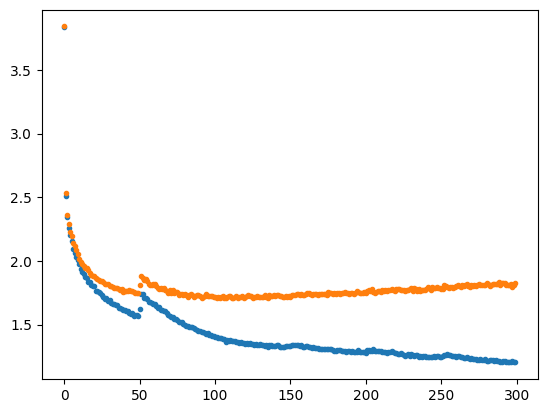

time: 118 ms (started: 2024-11-23 19:49:41 +00:00)


In [ ]:
plt.plot(train_loss_3[::2], linestyle = '', marker='.')
plt.plot(train_loss_3[1::2], linestyle = '', marker='.')
plt.show()

In [ ]:
max_iters = 5000
eval_interval = 100
learning_rate = 1e-4

optimizer = torch.optim.AdamW(model_2.parameters(), lr=learning_rate, weight_decay = 0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.9)

# Training loop
for iter in range(max_iters):
    # get a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model_2(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # print progress
    if iter % eval_interval == 0:
        losses = estimate_loss()
        train_loss_4.append(losses['train'])
        valid_loss_4.append(losses['val'])

        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

step 0: train loss 1.2480, val loss 1.7785
step 100: train loss 1.2578, val loss 1.7825
step 200: train loss 1.2643, val loss 1.8092
step 300: train loss 1.2583, val loss 1.8031
step 400: train loss 1.2661, val loss 1.7987
step 500: train loss 1.2651, val loss 1.7909
step 600: train loss 1.2602, val loss 1.7971
step 700: train loss 1.2562, val loss 1.7981
step 800: train loss 1.2551, val loss 1.7914
step 900: train loss 1.2517, val loss 1.7939
step 1000: train loss 1.2462, val loss 1.8044
step 1100: train loss 1.2527, val loss 1.8117
step 1200: train loss 1.2538, val loss 1.8018
step 1300: train loss 1.2469, val loss 1.7966
step 1400: train loss 1.2431, val loss 1.8095
step 1500: train loss 1.2369, val loss 1.8060
step 1600: train loss 1.2387, val loss 1.8120
step 1700: train loss 1.2444, val loss 1.8172
step 1800: train loss 1.2395, val loss 1.8023
step 1900: train loss 1.2338, val loss 1.7980
step 2000: train loss 1.2391, val loss 1.8115
step 2100: train loss 1.2270, val loss 1.8017


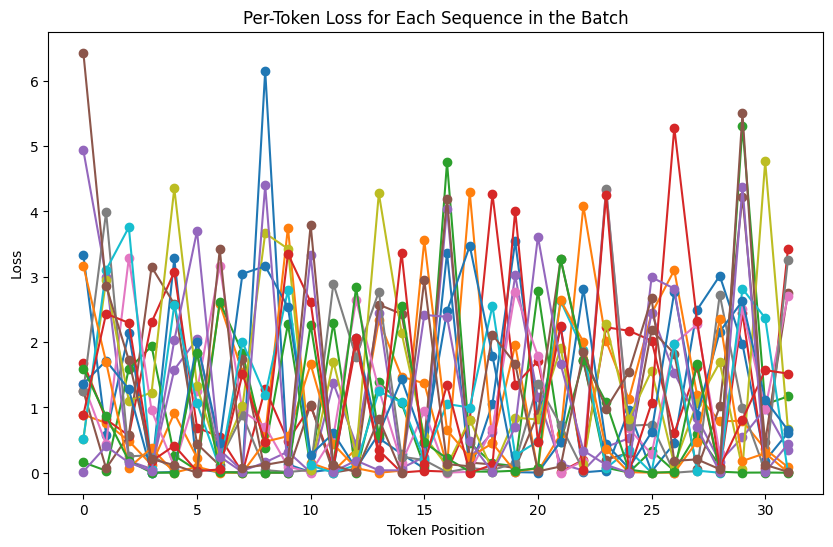

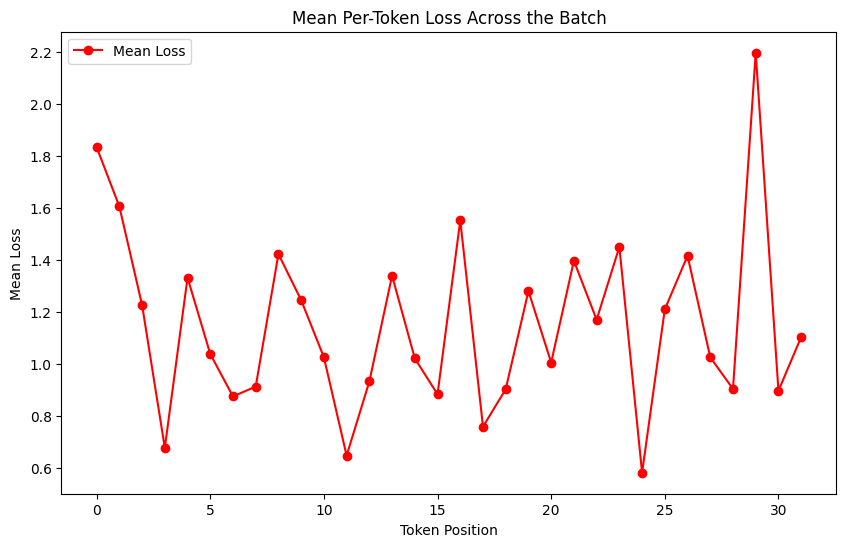

time: 458 ms (started: 2024-11-23 19:28:18 +00:00)


In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Compute logits and loss
xb, yb = get_batch('train')
logits, loss = model_2(xb, yb)

# Ensure logits and yb are shaped correctly
# logits: (batch_size, seq_len, vocab_size)
# yb: (batch_size, seq_len)

# Compute per-token loss
log_probs = F.log_softmax(logits, dim=-1)  # Compute log probabilities
loss_per_token = F.nll_loss(
    log_probs.view(-1, logits.size(-1)),  # Flatten logits
    yb.view(-1),                         # Flatten targets
    reduction='none'                     # Keep individual losses
).view(yb.size())  # Reshape back to (batch_size, seq_len)

# Plot per-token loss for each sequence in the batch
batch_size, seq_len = yb.size()
plt.figure(figsize=(10, 6))

for i in range(batch_size):
    token_losses = loss_per_token[i].detach().cpu().numpy()
    plt.plot(range(seq_len), token_losses, marker='o', label=f"Sequence {i}")

# Add labels, title, and legend
plt.xlabel("Token Position")
plt.ylabel("Loss")
plt.title("Per-Token Loss for Each Sequence in the Batch")
# plt.legend()
plt.show()

# Plot mean loss per token position across the batch
mean_loss_per_position = loss_per_token.mean(dim=0).detach().cpu().numpy()
plt.figure(figsize=(10, 6))
plt.plot(range(seq_len), mean_loss_per_position, marker='o', color='red', label="Mean Loss")

# Add labels, title, and legend
plt.xlabel("Token Position")
plt.ylabel("Mean Loss")
plt.title("Mean Per-Token Loss Across the Batch")
plt.legend()
plt.show()


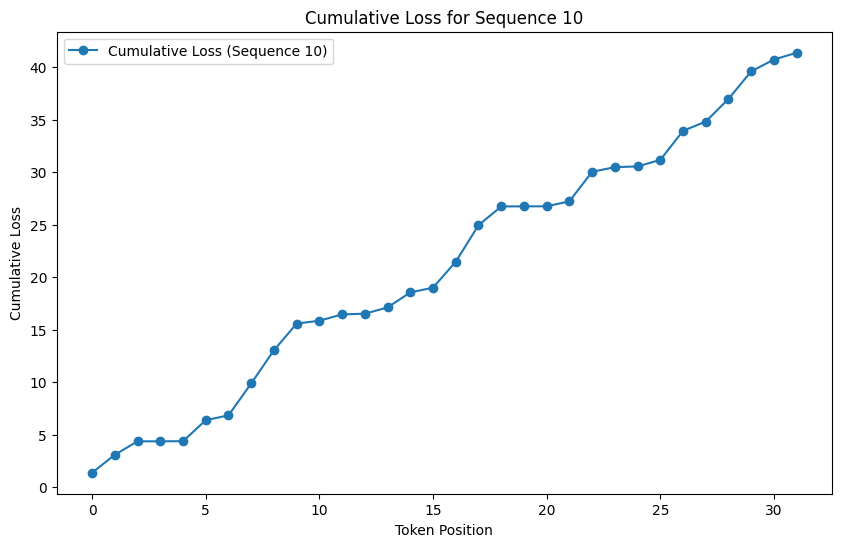

time: 212 ms (started: 2024-11-23 19:31:01 +00:00)


In [ ]:
# Compute cumulative loss for a single sequence
cumulative_loss = loss_per_token.cumsum(dim=1).detach().cpu().numpy()

# Plot cumulative loss for the example sequence
plt.figure(figsize=(10, 6))
plt.plot(range(seq_len), cumulative_loss[example_idx], marker='o', label=f"Cumulative Loss (Sequence {example_idx})")
plt.xlabel("Token Position")
plt.ylabel("Cumulative Loss")
plt.title(f"Cumulative Loss for Sequence {example_idx}")
plt.legend()
plt.show()


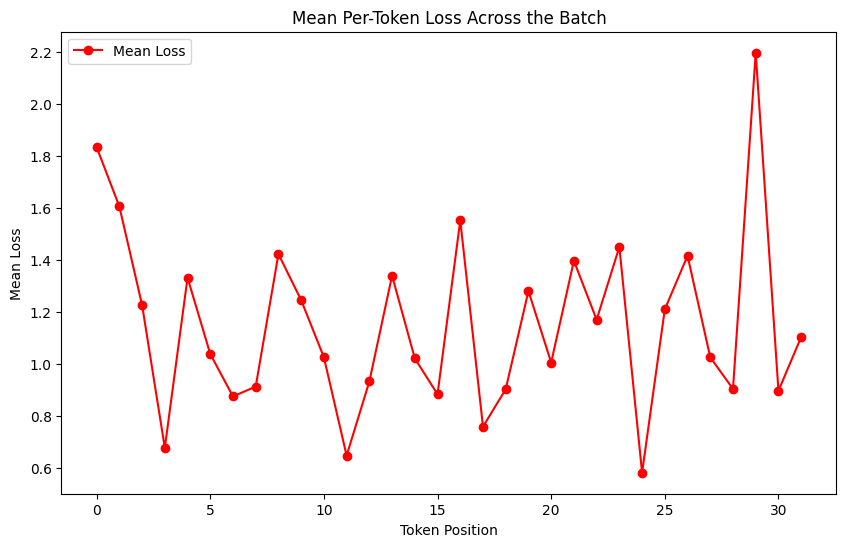

time: 197 ms (started: 2024-11-23 19:31:48 +00:00)


In [ ]:
mean_loss_per_position = loss_per_token.mean(dim=0).detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(range(seq_len), mean_loss_per_position, marker='o', color='red', label="Mean Loss")
plt.xlabel("Token Position")
plt.ylabel("Mean Loss")
plt.title("Mean Per-Token Loss Across the Batch")
plt.legend()
plt.show()

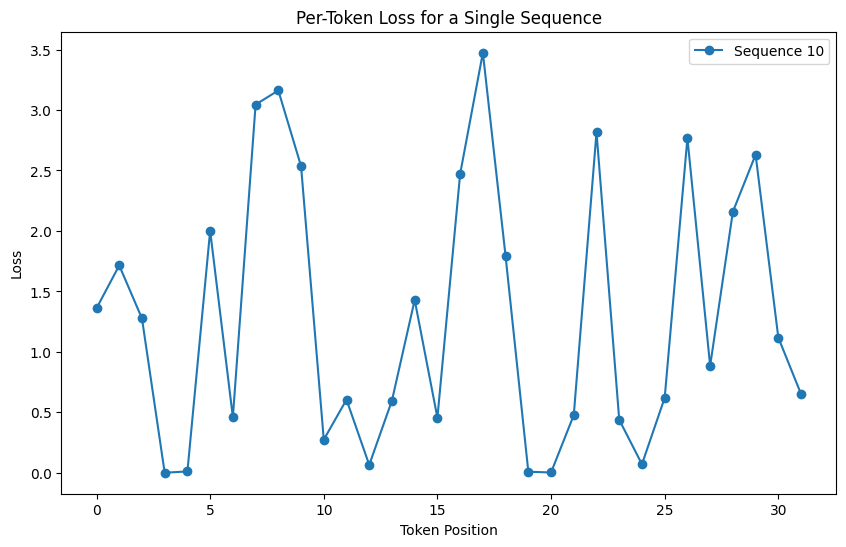

time: 194 ms (started: 2024-11-23 19:30:41 +00:00)


In [ ]:
example_idx = 10
token_losses = loss_per_token[example_idx].detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(range(seq_len), token_losses, marker='o', label=f"Sequence {example_idx}")
plt.xlabel("Token Position")
plt.ylabel("Loss")
plt.title("Per-Token Loss for a Single Sequence")
plt.legend()
plt.show()

Per-token loss for the first sequence:
tensor([1.3788e+00, 1.1607e-01, 7.7853e-01, 2.5250e-02, 6.2115e-02, 4.1257e+00,
        5.4302e-01, 5.4712e-01, 1.3400e-03, 1.7510e-04, 8.7159e-01, 3.5259e+00,
        2.3503e+00, 3.4073e-01, 5.1783e-04, 1.1604e+00, 8.5811e-02, 5.4788e-02,
        1.3308e-01, 2.2899e+00, 2.8127e+00, 2.5433e+00, 8.3776e-02, 1.2322e+00,
        4.1700e-01, 2.4242e+00, 5.2458e-01, 4.4463e+00, 1.2496e+00, 2.1455e+00,
        4.9088e-01, 2.1449e+00], device='cuda:0', grad_fn=<SelectBackward0>)
Mean loss per token position: tensor([1.7685, 1.4954, 1.1294, 1.0093, 1.9286, 1.3870, 0.6953, 0.9948, 1.1510,
        1.2319, 1.6448, 1.1173, 1.6514, 1.4582, 1.0657, 0.8660, 1.0733, 1.0624,
        0.8949, 1.2496, 0.9123, 1.5658, 1.1683, 1.8675, 1.1097, 1.7746, 1.5013,
        1.7873, 1.8460, 0.9805, 1.4175, 0.9706], device='cuda:0',
       grad_fn=<MeanBackward1>)


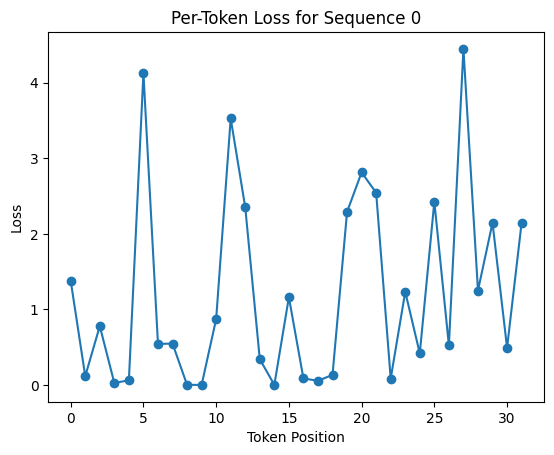

time: 164 ms (started: 2024-11-23 19:25:48 +00:00)


In [ ]:
xb, yb = get_batch('train')
logits, loss = model_2(xb, yb)

example_idx = 0
token_losses = loss_per_token[example_idx].detach().cpu().numpy()

print("Per-token loss for the first sequence:")
print(loss_per_token[0])


mean_loss_per_position = loss_per_token.mean(dim=0)
print("Mean loss per token position:", mean_loss_per_position)

plt.plot(token_losses, marker='o')
plt.xlabel("Token Position")
plt.ylabel("Loss")
plt.title(f"Per-Token Loss for Sequence {example_idx}")
plt.show()

In [ ]:
import re
import matplotlib.pyplot as plt
# # Simple plot
# plt.plot(train_loss)
# plt.plot(valid_loss)
# plt.show()

# Random generated output
# print(enc.decode(m.generate(context, max_new_tokens=100)[0].tolist()))
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(tokenizer.decode(model_2.generate(context, max_new_tokens=1000)[0].tolist()))

# Number of params
print(sum(p.numel() for p in model_2.parameters()), 'parameters')


Koporsóm után szalmaz,
A gyermekség orcsárdát kardjon túl,
Egy sírhalmodott költék be a derék!

Nagyúl-ép életem gátot.
Tudom ebben tartoztatpul:
»Följajítva vagy: s azóta is,
Szégyennek lelkednem...
Csak - Ha szivünk meglójoztatta,
Homályi kell czimborába,
Leszaggatodta is,
Siját majd gyakorodva munkát,
Hivatalhat szenvedtem... ha azaz a
Fiatal sötét anya...
De egy leuló utat,
De hol a hazáért,
A melyben csendesen te lot
Az erek,
Fogadsz folyónak!

Oh nekem én is kincset
E zárkodva lészsz szebbillantása
Jobb' fogjásom lehel,
A romba magyartotta olvassátok,
A fölszedte elottem.
Követ én neki toli zsivány a zavarnoksatokat.

Láng az örömivel,
Természet vigasztalhot,
Be istennek én nem multatjátok. Lugrak keresztületése!
Ajkaszorúban
Csak engem a istenet,
Melynek egyszer szómjaznak bánatot!

Fülem a házi fölére,
Ti kék egy szükség baját,
Hát a hóhér nem deresz te, és örvénynek,
Ha mennyiván györögösik,
És a sírhalom dobogúk.
Hogy szerette szétleai,
S fölrapja meglátogaták.
Mit bánt elot

In [ ]:
print(sum(p.numel() for p in model.parameters()), 'parameters')

832141 parameters


#Súlyok kiírása .csv-be

In [ ]:
# Write to Csv
import re
import tqdm

def write_parameter_to_csv(param, filename):
    with open(filename, 'w') as file:
        file.write("Row Index,Column Index,Value\n")
        total_elements = param.numel()
        with tqdm(total=total_elements) as pbar:
            for i in range(param.shape[0]):
                for j in range(param.shape[1]):
                    file.write(f"{i},{j},{param[i, j].item()}\n")
                    pbar.update(1)

def write_parameters_to_csv(model):
    for name, param in model.named_parameters():
        filename = f"{name}.csv"
        write_parameter_to_csv(param, filename)
        break

time: 788 µs (started: 2024-11-23 19:48:06 +00:00)


In [ ]:
write_parameters_to_csv(model_2)

TypeError: 'module' object is not callable

time: 18.7 ms (started: 2024-11-23 19:48:08 +00:00)
